<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/PyTorch/02_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (CNNs)

The original notebook created by [Andrada](https://www.kaggle.com/code/andradaolteanu/convolutional-neural-nets-cnns-explained)

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader as dl

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
import random
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


In [2]:
# SEED
def set_seed(seed = 7):
  '''Sets the seed of the entire notebook so
  results are the same every time we run.'''
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Small example; what is convolution?

Image shape: (320, 320, 3)


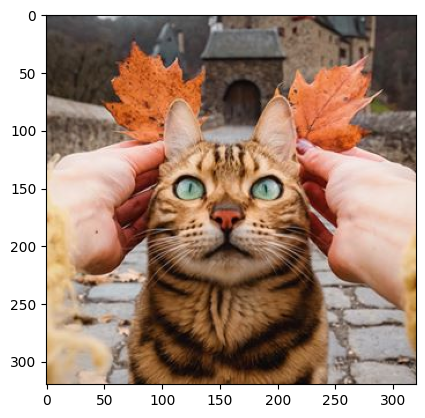

In [3]:
image = plt.imread('/content/suki.jpg')

print('Image shape:', image.shape)
plt.imshow(image)

In [4]:
# Before applying any convolutions...

# 1. convert to tensor
transform = transforms.ToTensor()
image = transform(image)
print('Image Tensor:', image.shape, '\n')

# 2. Bring the channel in front >> NO NEED <<
# image = image.permute(2, 0, 1)
# print('Permuted Channel:', image.shape, '\n')

# 3. Add one more dimension for batching (1 because we have one image)
image = image.reshape([1, 3, 320, 320]).float()
print('Final image shape:', image.shape, '\n')

Image Tensor: torch.Size([3, 320, 320]) 

Final image shape: torch.Size([1, 3, 320, 320]) 



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [5]:
# create 1 convolutional layer

conv1 = nn.Conv2d(in_channels=3, out_channels=5,
                  kernel_size=5, padding=0, stride=1)

# apply conv1 to image
conv1_img = conv1(image)
print('Convoluted Image shape:', conv1_img.shape)

Convoluted Image shape: torch.Size([1, 5, 316, 316])


In [6]:
# Convolution parameters
conv_params = list(conv1.parameters())
print('len(conv_params):', len(conv_params))
print('Filters:', conv_params[0].detach().numpy().shape)
print('Biases:', conv_params[1].detach().numpy().shape) # one for each channel

len(conv_params): 2
Filters: (5, 3, 5, 5)
Biases: (5,)


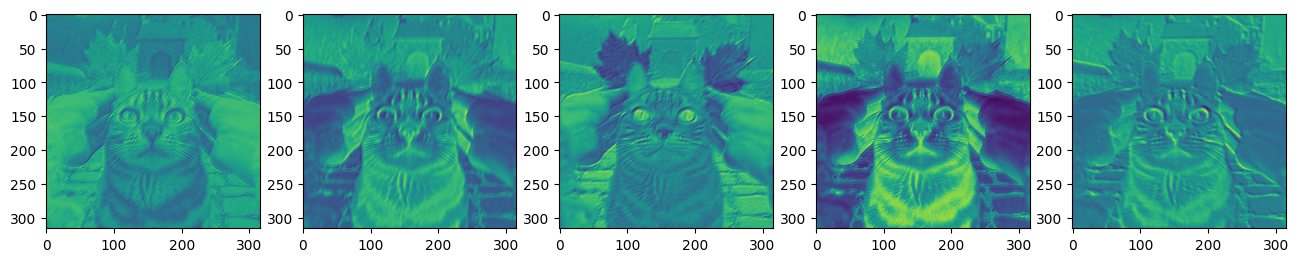

In [7]:
### Visualize Convolutions ###

conv1_numpy = conv1_img.detach().numpy()
conv1_numpy = conv1_numpy.reshape([5, 316, 316]) # remove the dim 1 batch

# Normalize to [0, 1] for plotting
max = np.max(conv1_numpy)
min = np.min(conv1_numpy)

conv1_numpy = conv1_numpy -min / (max - min) # Normalization

# plotting the channels
plt.figure(figsize=(16, 5))

for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(conv1_numpy[i])

# AlexNet

For more information [click here](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951)

In [8]:
# import alexNet
alexNet = torchvision.models.alexnet(pretrained=True)
alexNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 104MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# MNIST Classification using CNNs

## Build and try the model

The architecture will contain 2 main parts:
- `features`: which will take the images and put them through 2 convolutional layers that will learn features from the data.
- `classifier`: a feed forward neural net containing 2 hidden layers and 1 output layer that will classify based on the learned features from the image.

<blockquote><b>MaxPool()</b> to reduce computational load, after each convolution.
<br>
<br>
<div align="center">
<img width="240" alt="max pooling (2, 2)" src="https://i.imgur.com/rLACtHb.png">
</div>
<b>ReLU()</b> - It simply takes all the negative numbers in filter and turns them into 0.
</blockquote>

So, a natural techinque during convolutions is: `Conv2d` -> `ReLU` -> `MaxPool`

In [9]:
class CNN_MNISTClassifier(nn.Module):
  def __init__(self):
    super(CNN_MNISTClassifier, self).__init__()
    self.features = nn.Sequential(nn.Conv2d(1, 16, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2),
                                  nn.Conv2d(16, 10, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2))
    self.classifier = nn.Sequential(nn.Linear(10*5*5, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 84),
                                    nn.ReLU(),
                                    nn.Linear(84, 10))

  def forward(self, image, prints=False):
    if prints: print('Original Image shape:', image.detach().numpy().shape)

    image = self.features(image)
    if prints: print('Convol Image shape:', image.detach().numpy().shape)

    image = image.view(-1, 10*5*5)
    if prints: print('Vectorized Image shape:', image.detach().numpy().shape)

    out = self.classifier(image)
    if prints: print('out:', out)

    # Apply softmax
    out = F.log_softmax(out, dim=1)
    if prints: print('Log softmax (out):', out)
    return out

### Understand how it works

In [10]:
# create an instance of the model
model_example = CNN_MNISTClassifier()
model_example

CNN_MNISTClassifier(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=250, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [11]:
%%capture

# importing the MNIST data
mnist_example = MNIST('data', train=True, download=True,
                      transform=transforms.ToTensor())

image_ex, label_ex = list(mnist_example)[7]
image_ex = image_ex.reshape([1, 1, 28, 28])

In [12]:
# see how it works
out = model_example(image_ex, prints=True)

Original Image shape: (1, 1, 28, 28)
Convol Image shape: (1, 10, 5, 5)
Vectorized Image shape: (1, 250)
out: tensor([[-0.0228, -0.0412,  0.1211,  0.0916,  0.0502,  0.0902,  0.0795, -0.0128,
         -0.1271, -0.0202]], grad_fn=<AddmmBackward0>)
Log softmax (out): tensor([[-2.3490, -2.3673, -2.2050, -2.2345, -2.2760, -2.2359, -2.2466, -2.3389,
         -2.4533, -2.3463]], grad_fn=<LogSoftmaxBackward0>)


## Create criterion and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_example.parameters(),
                       lr=0.001, weight_decay=0.0005)

# == Compute loss ==
# Label Example has been transformed to tensor and reshaped
# so it suits the requirements of function
loss = criterion(out, torch.tensor(label_ex).reshape(1))
print('Loss:', loss)

# == Backpropagation ==

# clear all gradients
optimizer.zero_grad()
# compute gradients with respect to the loss
loss.backward()
# update parameters
optimizer.step()

Loss: tensor(2.2345, grad_fn=<NllLossBackward0>)


# Training on all images

In [14]:
mnist_train = MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor())
mnist_test = MNIST('data', train=False, download=True,
                   transform=transforms.ToTensor())

# Select only first 500 instances to make training fast
mnist_train = list(mnist_train)[:500]
mnist_test = list(mnist_test)[:500]

### Accuracy Function

In [18]:
def get_accuracy(model, data, batchSize=20):
  # set the model in evaluation mode
  model.eval()

  # create the dataloader
  data_loader = dl(data, batch_size=batchSize)

  correct_cases = 0
  total_cases = 0

  for (images, labels) in iter(data_loader):
    out = model(images)
    pred = out.max(dim=1)[1]

    correct_cases += (pred == labels).sum().item()
    total_cases += images.shape[0]
  return correct_cases/total_cases

### Training Function

<div align="center">
  <img alt="train network function"
  src="https://i.imgur.com/gGH4sLC.png">
</div>

In [20]:
def train_network(model, train_data, test_data, batchSize=20,
                  num_epochs=1, learning_rate=0.01, weight_decay=0,
                  show_plot=True, show_acc=True):

  print('Get data ready...')

  train_loader = dl(dataset=train_data, batch_size=batchSize, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                         weight_decay=weight_decay)

  losses = []
  iterations = []

  train_acc = []
  test_acc = []

  print('Training started...')
  iteration = 0

  for epoch in range(num_epochs):
    for images, labels in iter(train_loader):
      model.train()
      out = model(images)

      optimizer.zero_grad()
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

      iterations.append(iteration)
      iteration += 1
      losses.append(loss.data)

      train_acc.append(get_accuracy(model, train_data))
      test_acc.append(get_accuracy(model, test_data))

  if show_acc:
    print(f"Final Training Accuracy: {train_acc[-1]}", '\n' +
          f"Final Testing Accuracy: {test_acc[-1]}")

  if show_plot:
    plt.figure(figsize=(10,4))

    # Plot 1 -> Loss
    plt.subplot(1, 2, 1)
    plt.title("Loss Curve")
    plt.plot(iterations, losses, label="Train", color='gray')
    plt.xlabel('Iterations')
    plt.ylabel("Loss")

    # plot 2 -> Accuracy
    plt.subplot(1, 2, 2)
    plt.title("Accuracy Curve")
    plt.plot(iterations, train_acc, label="Train", color='gray')
    plt.plot(iterations, test_acc, label="Test", color='black')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()

Get data ready...
Training started...
Final Training Accuracy: 1.0 
Final Testing Accuracy: 0.906


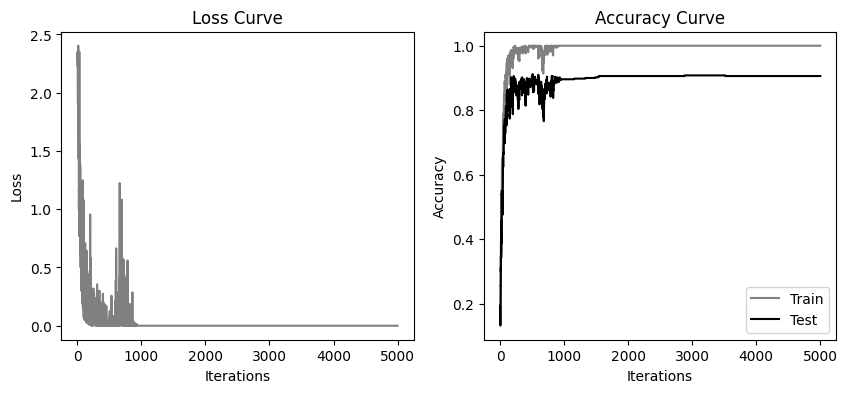

In [21]:
# create model instance
model1 = CNN_MNISTClassifier()
train_network(model1, mnist_train, mnist_test, num_epochs=200)

Text(0.5, 1.0, 'Confusion Matrix')

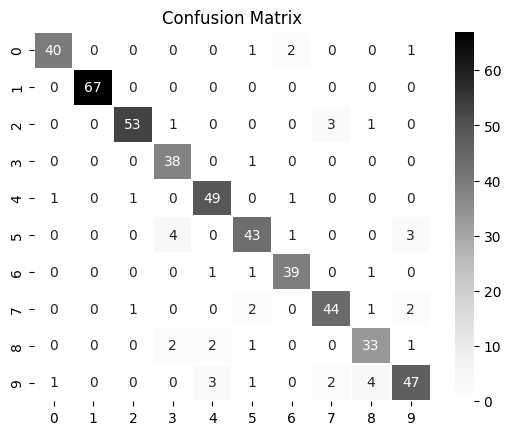

In [29]:
# confusion matrix
def confusion_matrix(model, test_data):
  torch.no_grad() # disable gradient computing
  model.eval()

  preds, actuals = [], []

  for image, label in test_data:
    image = image.unsqueeze(0) # add 1 dimension for batching
    out = model(image)

    pred = torch.max(out, dim=1)[1].item()
    preds.append(pred)
    actuals.append(label)

  return metrics.confusion_matrix(preds, actuals)


# get the plot
sns.heatmap(confusion_matrix(model1, mnist_test), linewidths=0.1,
            annot=True, fmt='g', cmap='Greys')
plt.title('Confusion Matrix')